Binary 2/6 A)

mRNA localization using binary classification (cytoplasm/mitochondria) (part 1/2): basic model with: 
<br> 
<br>
a) Method 1: no feature selection and <br>
b) Method 2: with feature importance-based feature selection (get_feature_importance type (default) =  EFstrType.FeatureImportance, i.e. PredictionValuesChange) <br>
c) Method 3: with feature importance-based feature selection (feature importance type: SHAP values)

In [1]:
import pandas as pd
from catboost import CatBoostClassifier
from catboost import Pool
import matplotlib.pyplot as plt
import numpy as np
import shap

In [2]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score, roc_auc_score, precision_recall_curve, roc_curve, auc, f1_score, classification_report


In [3]:
#data initialization

#Cytoplasm (label = 0)
CP_train = pd.read_csv("../../Data/InputData/CP_iLearnfeatvalues_train_CSV.csv")
CP_test = pd.read_csv("../../Data/InputData/CP_iLearnfeatvalues_test_CSV.csv")

#Mitochondria (label = 2)
MT_train = pd.read_csv("../../Data/InputData/MT_iLearnfeatvalues_train_CSV.csv")
MT_test = pd.read_csv("../../Data/InputData/MT_iLearnfeatvalues_test_CSV.csv")

print("CP TRAIN, TEST SHAPE:", CP_train.shape, ",", CP_test.shape)
print("MT TRAIN, TEST SHAPE:", MT_train.shape, ",", MT_test.shape)

CP TRAIN, TEST SHAPE: (824, 1026) , (206, 1026)
MT TRAIN, TEST SHAPE: (280, 1026) , (70, 1026)


In [4]:
###### NEXT STEP #######
#Merge training files for binary classification (CP+ER, CP+MT, CP+NU, ER+MT, ER+NU, MT+NU)
#Merge testing files same way

#How to merge: 
# - https://saturncloud.io/blog/how-to-merge-two-csv-files-into-one-with-pandas-by-id/
# or pd.concat


In [5]:


#Group 2: CP + MT

frames_CM_tra = [CP_train, MT_train]
frames_CM_tes = [CP_test, MT_test]

CP_MT_train = pd.concat(frames_CM_tra)
CP_MT_test = pd.concat(frames_CM_tes)


In [6]:

print("CP + MT TRAIN, TEST SHAPE:", CP_MT_train.shape, ",", CP_MT_test.shape)


CP + MT TRAIN, TEST SHAPE: (1104, 1026) , (276, 1026)


In [7]:
CP_MT_test.head(209)

,#,label,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,mRNALoc_16986#79230|0|testing,0,0.008836,0.002834,0.002334,0.003168,0.001667,0.003168,0.000000,0.002001,...,0.000834,0.001834,0.001167,0.000500,0.001667,0.001834,0.001667,0.002501,0.002001,0.011504
1,mRNALoc_8139#3082|0|testing,0,0.009503,0.002501,0.003168,0.006002,0.003001,0.000834,0.000167,0.002668,...,0.000167,0.003168,0.001667,0.001334,0.001667,0.003501,0.005835,0.001667,0.003501,0.005669
2,mRNALoc_19034#8816|0|testing,0,0.006005,0.001168,0.002168,0.001168,0.001668,0.001334,0.000167,0.000334,...,0.000167,0.001168,0.000834,0.001501,0.000667,0.001668,0.002502,0.001001,0.001334,0.002002
3,mRNALoc_19863#9737|0|testing,0,0.005673,0.001335,0.002503,0.002837,0.001502,0.001335,0.000167,0.001001,...,0.000000,0.001168,0.002002,0.001001,0.002670,0.001001,0.001168,0.000834,0.001669,0.001502
4,mRNALoc_19031#8816|0|testing,0,0.006008,0.001168,0.002170,0.001168,0.001669,0.001335,0.000167,0.000334,...,0.000167,0.001168,0.000834,0.001502,0.000668,0.001669,0.002503,0.001001,0.001335,0.002003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,mRNALoc_8179#30957|0|testing,0,0.000732,0.000183,0.000366,0.000732,0.000549,0.000366,0.000183,0.000732,...,0.000000,0.000183,0.000366,0.000732,0.000732,0.000549,0.000183,0.000183,0.000549,0.000000
205,mRNALoc_19660#94229|0|testing,0,0.006595,0.001465,0.002748,0.002565,0.002015,0.000550,0.000183,0.001099,...,0.000183,0.002381,0.003114,0.001649,0.001465,0.001832,0.002931,0.002565,0.003297,0.004396
0,mRNALoc_18808#856050|2|testing,2,0.001747,0.001747,0.005240,0.005240,0.001747,0.000873,0.002620,0.001747,...,0.000873,0.001747,0.001747,0.001747,0.001747,0.001747,0.001747,0.000873,0.001747,0.003493
1,mRNALoc_18516#852314|2|testing,2,0.010536,0.004390,0.004390,0.006146,0.003512,0.001756,0.000878,0.001756,...,0.000000,0.002634,0.003512,0.000878,0.003512,0.000878,0.001756,0.002634,0.004390,0.000000


In [8]:
#FOR CP+MT
noname_CM_train = CP_MT_train.drop("#", axis="columns")
noname_CM_test = CP_MT_test.drop("#", axis="columns")


CP_MT_X_train = noname_CM_train.drop("label", axis="columns")
CP_MT_y_train = noname_CM_train["label"]

CP_MT_X_test = noname_CM_test.drop("label", axis="columns")
CP_MT_y_test = noname_CM_test["label"]

print("CP + MT X train:", CP_MT_X_train.shape)
print("CP + MT y train:", CP_MT_y_train.shape)
print("CP + MT X test:", CP_MT_X_test.shape)
print("CP + MT y test:", CP_MT_y_test.shape)

CP + MT X train: (1104, 1024)
CP + MT y train: (1104,)
CP + MT X test: (276, 1024)
CP + MT y test: (276,)


In [9]:
# Create data pools for feature importance/selection for CP + MT

CM_feature_names = list(CP_MT_X_train.columns)
print("Number of features:", len(CM_feature_names))

CM_train_pool = Pool(CP_MT_X_train, CP_MT_y_train, feature_names=CM_feature_names)

CM_test_pool = Pool(CP_MT_X_test, CP_MT_y_test)

print("*Cytoplasm, Mitochondria Pools created")

Number of features: 1024
*Cytoplasm, Mitochondria Pools created


Initial classification (without feature importance/selection/hyperparameter tuning)

In [10]:
CM_binary_model = CatBoostClassifier(loss_function="MultiClass")

In [11]:
#Fit model to CM data

CM_binary_model.fit(CM_train_pool)

Learning rate set to 0.079527
0:	learn: 0.6385453	total: 195ms	remaining: 3m 14s
1:	learn: 0.5928234	total: 318ms	remaining: 2m 38s
2:	learn: 0.5505704	total: 433ms	remaining: 2m 23s
3:	learn: 0.5132743	total: 547ms	remaining: 2m 16s
4:	learn: 0.4791225	total: 662ms	remaining: 2m 11s
5:	learn: 0.4486560	total: 783ms	remaining: 2m 9s
6:	learn: 0.4209915	total: 900ms	remaining: 2m 7s
7:	learn: 0.3940899	total: 1.02s	remaining: 2m 6s
8:	learn: 0.3697795	total: 1.14s	remaining: 2m 5s
9:	learn: 0.3472277	total: 1.26s	remaining: 2m 4s
10:	learn: 0.3264301	total: 1.41s	remaining: 2m 6s
11:	learn: 0.3084585	total: 1.53s	remaining: 2m 5s
12:	learn: 0.2910456	total: 1.64s	remaining: 2m 4s
13:	learn: 0.2771808	total: 1.76s	remaining: 2m 4s
14:	learn: 0.2629835	total: 1.88s	remaining: 2m 3s
15:	learn: 0.2490119	total: 1.99s	remaining: 2m 2s
16:	learn: 0.2361546	total: 2.1s	remaining: 2m 1s
17:	learn: 0.2245013	total: 2.22s	remaining: 2m 1s
18:	learn: 0.2136407	total: 2.39s	remaining: 2m 3s
19:	lea

In [12]:
#Check parameters used in this model fit

CM_bin_params = CM_binary_model.get_all_params()
print("Basic model parameters:", CM_bin_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [0, 2], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'MultiClass', 'learning_rate': 0.07952699810266495,

In [13]:
#Prediction using X_test
CM_y_pred = CM_binary_model.predict(CP_MT_X_test)

#Predication probability

CM_y_prob = CM_binary_model.predict_proba(CP_MT_X_test)

In [15]:
# Calculate F1 score and get classification report

print("Model 1: Basic model - Cytoplasm & mitochondira")

CM_cr = classification_report(CP_MT_y_test, CM_y_pred, digits=3)
print(CM_cr)

print('Accuracy score: ', accuracy_score(CP_MT_y_test, CM_y_pred))

CM_f1 = f1_score(CP_MT_y_test, CM_y_pred, average='macro')
print(f"F1 Score: {CM_f1}")

# print('Roc auc score : ', roc_auc_score(CP_MT_y_test, CM_y_prob))

Model 1: Basic model - Cytoplasm & mitochondira
              precision    recall  f1-score   support

           0      0.995     1.000     0.998       206
           2      1.000     0.986     0.993        70

    accuracy                          0.996       276
   macro avg      0.998     0.993     0.995       276
weighted avg      0.996     0.996     0.996       276

Accuracy score:  0.9963768115942029
F1 Score: 0.9951922239448151


In [16]:
# Confusion matrix for selected data

print("real values shape:", CP_MT_y_test.shape)
print("prediction shape:", CM_y_pred.shape)

CM_y_pred_fl = CM_y_pred
print("flattened prediction values shape:", CM_y_pred_fl.ravel().shape, "\n")

CM_cMatrix = confusion_matrix(CP_MT_y_test, CM_y_pred_fl)
print(CM_cMatrix)

real values shape: (276,)
prediction shape: (276, 1)
flattened prediction values shape: (276,) 

[[206   0]
 [  1  69]]


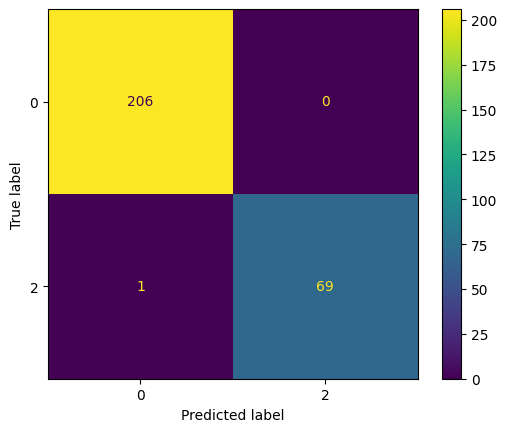

In [17]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=CM_cMatrix, display_labels=CM_binary_model.classes_)
disp.plot()
plt.show()

    Method 2: Feature importance-based feature selection

In [18]:
#Feature importances for CM pair

CM_feat_importances = CM_binary_model.get_feature_importance(prettified=True)
CM_feat_importances.head(100)

,Feature Id,Importances
0,TATCG,9.201081
1,CCCCC,5.027435
2,ACGAA,3.133898
3,TTACG,2.614947
4,CAGCC,2.538007
...,...,...
95,TCAAG,0.184023
96,CATTG,0.182816
97,CAGGG,0.182110
98,CTGGG,0.179269


In [19]:
# Show only feature importances above 0.1

threshold_chosen_features = CM_feat_importances[CM_feat_importances['Importances'] >= 0.1]
num_chosen_features = len(threshold_chosen_features)

print(threshold_chosen_features)

print("\nAmount of features with importnace above 0.1 (selected features):", num_chosen_features)

    Feature Id  Importances
0        TATCG     9.201081
1        CCCCC     5.027435
2        ACGAA     3.133898
3        TTACG     2.614947
4        CAGCC     2.538007
..         ...          ...
159      ACAAC     0.104258
160      GTGGA     0.102289
161      TGGGA     0.101363
162      ATTCA     0.101352
163      GCTCT     0.100955

[164 rows x 2 columns]

Amount of features with importnace above 0.1 (selected features): 164


In [20]:
print("Sum of total feature importances: ", sum(CM_feat_importances.Importances))
print("Sum of feature importances > 0: ", sum(threshold_chosen_features.Importances))

Sum of total feature importances:  99.99999999999991
Sum of feature importances > 0:  85.80846687752029


In [21]:
# Select features with importance values above 0.1

CM_selected_feat = CM_feat_importances[:num_chosen_features]['Feature Id'].tolist()

print(CM_selected_feat)

['TATCG', 'CCCCC', 'ACGAA', 'TTACG', 'CAGCC', 'TCCAA', 'CGGTA', 'ACGTT', 'TCGTT', 'CCCAG', 'ATTGG', 'TCGAA', 'TTCGT', 'CAGCA', 'CGTTA', 'CAGCT', 'CCTCC', 'TCAGC', 'TGGTA', 'GCCTG', 'CTCAG', 'CTGAG', 'TGTAA', 'ACGAT', 'TGACG', 'CGATT', 'CACAG', 'TATGG', 'CCCCT', 'GGCCT', 'TTCGA', 'GGTAT', 'CCTGG', 'CGATA', 'CGTTG', 'ATTGA', 'TTGGT', 'CAGTC', 'GTCGT', 'CTATT', 'GGGGC', 'GGTAC', 'CGATG', 'AGCAG', 'TCGAT', 'GGGCC', 'GTGTG', 'TAACG', 'CACCC', 'CCCTG', 'CGTAA', 'GACCT', 'TATTG', 'TACGA', 'CCGAT', 'CCAGG', 'CGAAA', 'GGTAA', 'ATCGT', 'ATACG', 'TTGCG', 'ACGCT', 'ATCAA', 'CCGAG', 'ATTAC', 'ACACA', 'GGGAG', 'GCGAA', 'ATCCG', 'TCCTG', 'AAAAA', 'GGCAT', 'AGCCC', 'ATCGA', 'TTTCG', 'CTCCC', 'CGTAT', 'ATCGG', 'TTTTT', 'CGCGC', 'CCCGG', 'ACCCC', 'GTCTA', 'TGTGT', 'CTGGC', 'AATGT', 'TTCAG', 'TGGAA', 'GACGT', 'GCATC', 'ATTCG', 'CGTCA', 'CAATT', 'TACGG', 'AGTCC', 'TCAAG', 'CATTG', 'CAGGG', 'CTGGG', 'CGTTT', 'TATTC', 'CAATC', 'CCGCG', 'GGCGG', 'TGGGT', 'TCATT', 'TGTCA', 'TCAGA', 'CGGCG', 'GCTTG', 'GATGT', 

In [22]:
CP_MT_X_train.shape

(1104, 1024)

In [23]:
# See original training set

CP_MT_X_train.head(826)


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.003643,0.000792,0.001426,0.002218,0.001584,0.000950,0.000792,0.000950,0.001901,0.001742,...,0.000000,0.002693,0.002059,0.001109,0.001109,0.002534,0.001584,0.001901,0.003168,0.003643
1,0.002914,0.000291,0.000583,0.000291,0.000583,0.000000,0.000000,0.000583,0.000874,0.001457,...,0.000583,0.000291,0.000583,0.000291,0.000000,0.001166,0.000291,0.001166,0.000583,0.000291
2,0.002291,0.001375,0.000458,0.001375,0.000000,0.000917,0.000458,0.001375,0.001375,0.000917,...,0.000917,0.001375,0.000917,0.000458,0.000458,0.000917,0.000917,0.002750,0.000458,0.000458
3,0.000000,0.000990,0.000495,0.000000,0.000990,0.000990,0.000000,0.000495,0.001484,0.000000,...,0.000000,0.000495,0.000990,0.000000,0.001484,0.000495,0.000495,0.000000,0.000000,0.000000
4,0.013061,0.002488,0.004043,0.004354,0.001451,0.001348,0.000415,0.002902,0.003110,0.001244,...,0.000311,0.001762,0.001970,0.000933,0.002591,0.001970,0.002695,0.002384,0.002488,0.003732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,0.004328,0.002331,0.002331,0.002664,0.002997,0.000499,0.000000,0.001665,0.002331,0.002664,...,0.000000,0.002664,0.001998,0.001665,0.001332,0.003329,0.002331,0.001998,0.002664,0.003995
822,0.004830,0.001499,0.002498,0.004997,0.002332,0.001332,0.000333,0.000833,0.001832,0.001166,...,0.000000,0.002498,0.002831,0.001332,0.001832,0.003664,0.006329,0.002998,0.003831,0.008494
823,0.002500,0.000167,0.000500,0.000167,0.000500,0.000667,0.000167,0.000667,0.000667,0.000333,...,0.000167,0.000667,0.001167,0.000167,0.000333,0.000333,0.000333,0.000167,0.000167,0.000500
0,0.003945,0.001255,0.002690,0.002152,0.001435,0.000359,0.001076,0.001435,0.001973,0.001435,...,0.001614,0.001255,0.003407,0.001435,0.001435,0.001973,0.001435,0.001435,0.002869,0.001435


In [24]:
#Create training set with selected features 

CM_X_train_selected = CP_MT_X_train[CM_selected_feat]
CM_X_train_selected.head()

,TATCG,CCCCC,ACGAA,TTACG,CAGCC,TCCAA,CGGTA,ACGTT,TCGTT,CCCAG,...,GTACT,TAGAC,ATACA,AAACG,AGGGT,ACAAC,GTGGA,TGGGA,ATTCA,GCTCT
0,0.000000,0.001267,0.000475,0.000158,0.000792,0.001584,0.000158,0.000000,0.000317,0.002376,...,0.000317,0.000950,0.000475,0.000792,0.000950,0.001109,0.001267,0.001584,0.000950,0.001426
1,0.000000,0.003205,0.000000,0.000000,0.004662,0.001166,0.000000,0.000583,0.000291,0.003497,...,0.000291,0.000000,0.000291,0.000000,0.002331,0.000291,0.001748,0.002040,0.000291,0.001748
2,0.000458,0.000458,0.000000,0.000000,0.001833,0.002750,0.000000,0.000000,0.000458,0.002750,...,0.000458,0.000917,0.000458,0.000458,0.000458,0.000917,0.000917,0.000917,0.000458,0.000917
3,0.000000,0.004948,0.000000,0.000000,0.003464,0.000990,0.000000,0.000000,0.000000,0.004453,...,0.000495,0.000495,0.000000,0.000000,0.000990,0.000495,0.000495,0.001979,0.000000,0.001979
4,0.000000,0.000622,0.000415,0.000207,0.001037,0.001037,0.000000,0.000207,0.000104,0.002073,...,0.000415,0.000415,0.001140,0.000415,0.000933,0.001140,0.001762,0.002384,0.001659,0.001451


In [25]:
# Check whether columns in new training set are the same featues are the ones selected
if(list(CM_X_train_selected.columns) == CM_selected_feat):
    print("Selected and column features are the same; properly selected");
else:
    print("Features not selected properly")

Selected and column features are the same; properly selected


In [26]:
# Check whether number of variables/sequences of training set is the same as number of labels (no change should have been made to the sequences (rows), only to the features (columns)) 
print("Shape of X_train_selected (number of variables/sequences):", CM_X_train_selected.shape)
print("Shape of y_train (number of labels):", CP_MT_y_train.shape)

Shape of X_train_selected (number of variables/sequences): (1104, 164)
Shape of y_train (number of labels): (1104,)


In [27]:
# Create pool object for selected feature data
print("Original number of features:", len(CM_feature_names), "\n Number of selected features:", len(CM_selected_feat))

CM_selected_train_pool = Pool(CM_X_train_selected, CP_MT_y_train, feature_names=CM_selected_feat)

Original number of features: 1024 
 Number of selected features: 164


In [28]:
#Create new model for data with selected features
CM_FIFS_model = CatBoostClassifier(loss_function="MultiClass")

# Fit new data into same model as before

CM_FIFS_model.fit(CM_selected_train_pool)

Learning rate set to 0.079527
0:	learn: 0.6367471	total: 37.3ms	remaining: 37.3s
1:	learn: 0.5871131	total: 68.1ms	remaining: 34s
2:	learn: 0.5424898	total: 92.3ms	remaining: 30.7s
3:	learn: 0.5049454	total: 125ms	remaining: 31.2s
4:	learn: 0.4695947	total: 146ms	remaining: 29.1s
5:	learn: 0.4385329	total: 168ms	remaining: 27.8s
6:	learn: 0.4123636	total: 191ms	remaining: 27.1s
7:	learn: 0.3851456	total: 214ms	remaining: 26.5s
8:	learn: 0.3616252	total: 237ms	remaining: 26.1s
9:	learn: 0.3389116	total: 260ms	remaining: 25.7s
10:	learn: 0.3193105	total: 284ms	remaining: 25.5s
11:	learn: 0.2998864	total: 306ms	remaining: 25.2s
12:	learn: 0.2823926	total: 327ms	remaining: 24.9s
13:	learn: 0.2650499	total: 351ms	remaining: 24.8s
14:	learn: 0.2500593	total: 375ms	remaining: 24.6s
15:	learn: 0.2362055	total: 399ms	remaining: 24.5s
16:	learn: 0.2236073	total: 423ms	remaining: 24.5s
17:	learn: 0.2124925	total: 448ms	remaining: 24.5s
18:	learn: 0.2020709	total: 487ms	remaining: 25.1s
19:	learn:

In [29]:
#Check parameters used in this model fit

CM_FIFS_params = CM_FIFS_model.get_all_params()
print("Basic model parameters:", CM_FIFS_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [0, 2], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'MultiClass', 'learning_rate': 0.07952699810266495,

In [30]:
#Prediction using X_test only for selected features data
CM_FIFS_y_pred = CM_FIFS_model.predict(CP_MT_X_test)

#Predication probability for selected features data

CM_FIFS_y_prob = CM_FIFS_model.predict_proba(CP_MT_X_test)

In [31]:
# Calculate F1 score and get classification report

print("Model 2: Feature selection (PredictionValuesChange) - Cytoplasm & mitochondira")

print("\nNumber of chosen features:", num_chosen_features, "\n")

CM_FIFS_cr = classification_report(CP_MT_y_test, CM_FIFS_y_pred, digits=3)
print(CM_FIFS_cr)

print('Accuracy score: ', accuracy_score(CP_MT_y_test, CM_FIFS_y_pred))

CM_FIFS_f1 = f1_score(CP_MT_y_test, CM_FIFS_y_pred, average='macro')
print(f"F1 Score: {CM_FIFS_f1}")
# print('Roc auc score : ', roc_auc_score(CP_MT_y_test, CM_FIFS_y_prob))

Model 2: Feature selection (PredictionValuesChange) - Cytoplasm & mitochondira

Number of chosen features: 164 

              precision    recall  f1-score   support

           0      0.995     0.995     0.995       206
           2      0.986     0.986     0.986        70

    accuracy                          0.993       276
   macro avg      0.990     0.990     0.990       276
weighted avg      0.993     0.993     0.993       276

Accuracy score:  0.9927536231884058
F1 Score: 0.9904299583911235


In [32]:
# Confusion matrix for selected data

print("real values shape:", CP_MT_y_test.shape)
print("prediction shape:", CM_FIFS_y_pred.shape)

CM_FIFS_y_pred_fl = CM_FIFS_y_pred
print("flattened prediction values shape:", CM_FIFS_y_pred_fl.ravel().shape, "\n")

CM_FIFS_cMatrix = confusion_matrix(CP_MT_y_test, CM_FIFS_y_pred_fl)
print(CM_FIFS_cMatrix)

real values shape: (276,)
prediction shape: (276, 1)
flattened prediction values shape: (276,) 

[[205   1]
 [  1  69]]


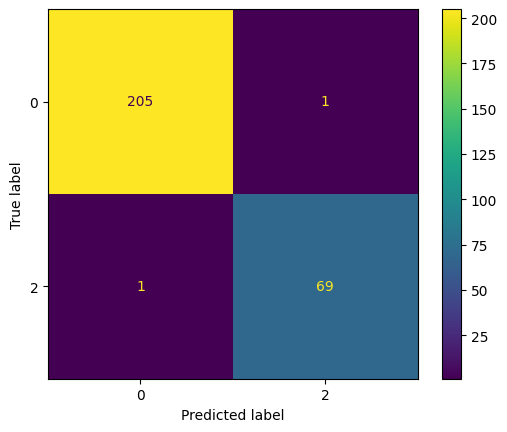

In [33]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=CM_FIFS_cMatrix, display_labels=CM_FIFS_model.classes_)
disp.plot()
plt.show()

    Method 3: Modelling using feature selection based on feature importance values (with get_feature_importances type = "ShapValues")

In [34]:
#SHAP explainer to explain CatBoost output
explainer = shap.TreeExplainer(CM_binary_model)

In [35]:
#SHAP values for X_train
CM_shap_values = explainer.shap_values(CP_MT_X_train)

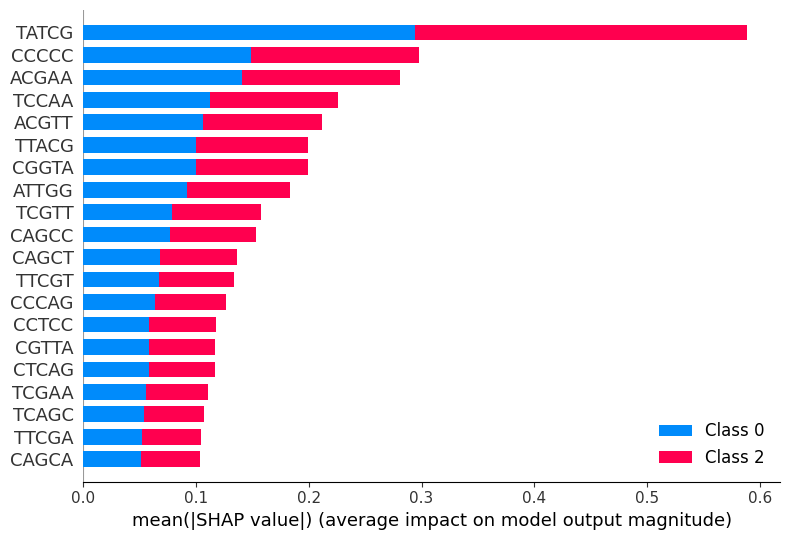

In [58]:
shap.summary_plot(CM_shap_values, CP_MT_X_train, plot_size=0.2, class_names=["Class 0", "Class 2"])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


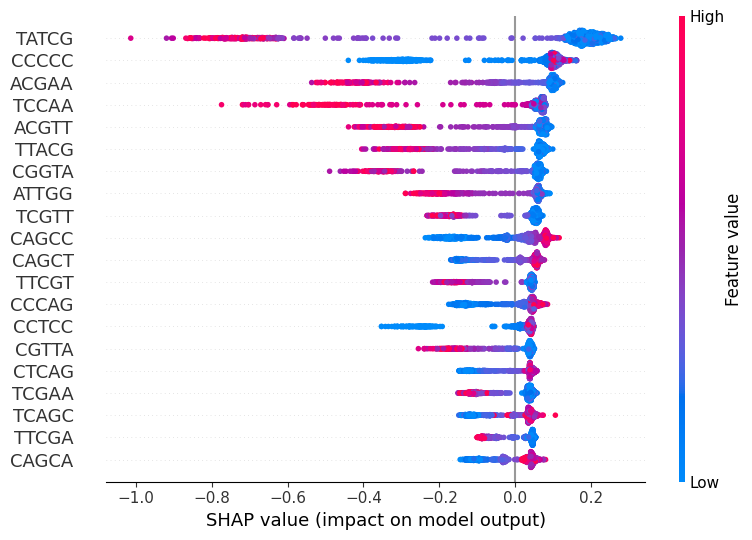

In [37]:
shap.summary_plot(CM_shap_values[0], CP_MT_X_train, plot_size=0.2)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


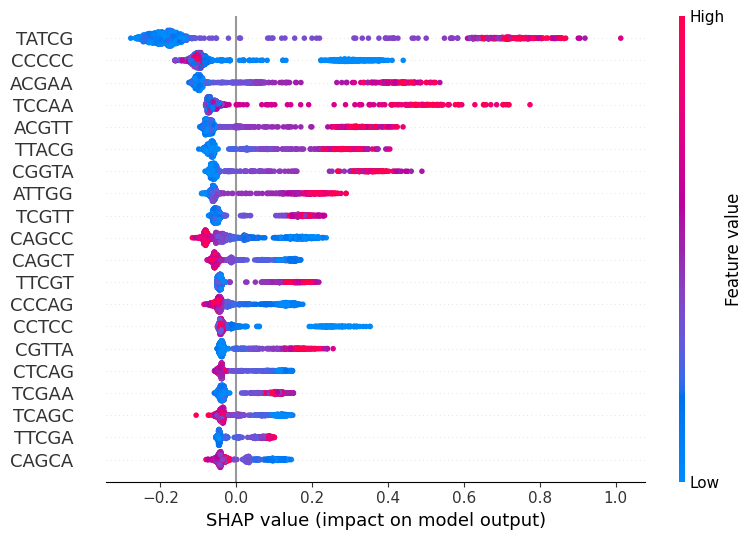

In [38]:
shap.summary_plot(CM_shap_values[1], CP_MT_X_train, plot_size=0.2)

In [39]:
shap_df = pd.DataFrame(CM_shap_values[0], columns=CP_MT_X_train.columns)


In [40]:
CM_shap_FI = (shap_df[shap_df>0]
                                .mean()
                                .sort_values(ascending=False)
                                .reset_index()
                                .rename(columns={'index':'Feature Id', 0:'Importances'})
                                # .head()
                        )

In [41]:
CM_shap_FI.head(100)

#### Check these feautre values with the features on shap plot for CP above #####
# Might need to use other method to get only features in with positive outcome + in red (those in red on right side):


,Feature Id,Importances
0,TATCG,0.189363
1,CCCCC,0.098708
2,ACGAA,0.096144
3,ACGTT,0.070300
4,TGTAA,0.068956
...,...,...
95,AGCAG,0.010619
96,GGGCC,0.010426
97,ATCAA,0.010309
98,CATTG,0.010241


In [42]:
# shap.summary_plot(CM_shap_values[0], CP_MT_X_train, show=False, max_display=30, plot_size=0.2)

In [43]:
#Classifier results with CM_feature_importance

In [47]:
# Show only feature importances above 0.017 (0.05/3 = 0.017)

CM_SHAP_thres_chosen = CM_shap_FI[CM_shap_FI['Importances'] >= 0.017]
CM_shap_num_chosen = len(CM_SHAP_thres_chosen)

print(CM_SHAP_thres_chosen)

print("\nAmount of features with importnace above 0.017 (selected features):", CM_shap_num_chosen)

   Feature Id  Importances
0       TATCG     0.189363
1       CCCCC     0.098708
2       ACGAA     0.096144
3       ACGTT     0.070300
4       TGTAA     0.068956
5       TTACG     0.067597
6       TCCAA     0.063045
7       ATTGG     0.060920
8       CGGTA     0.058987
9       CAGCC     0.054610
10      TCGTT     0.052704
11      AAATA     0.049417
12      CAGCT     0.047453
13      GGTAC     0.045201
14      TTAAG     0.044685
15      TTCGT     0.043229
16      TTCGA     0.042956
17      CAGCA     0.041746
18      CCCAG     0.041734
19      CTCAG     0.041265
20      TCAGC     0.039938
21      TCGAA     0.038716
22      CGTTA     0.038584
23      AAAAA     0.035677
24      GCCTG     0.035566
25      TATGG     0.032903
26      CCTCC     0.032892
27      AAACA     0.029744
28      CTGAG     0.029334
29      TGACG     0.028053
30      GGCCT     0.024938
31      GTCGT     0.024288
32      CACAG     0.024281
33      GGTAT     0.023527
34      CAGTC     0.023288
35      CCTGG     0.022876
3

In [48]:
print("Sum of total feature importances: ", sum(CM_shap_FI.Importances))
print("Sum of feature importances > 0: ", sum(CM_SHAP_thres_chosen.Importances))

Sum of total feature importances:  nan
Sum of feature importances > 0:  2.013647419960251


In [49]:
# Select features with importance values above 0.1

CM_shap_selected_feat = CM_shap_FI[:CM_shap_num_chosen]['Feature Id'].tolist()

print(CM_shap_selected_feat)

['TATCG', 'CCCCC', 'ACGAA', 'ACGTT', 'TGTAA', 'TTACG', 'TCCAA', 'ATTGG', 'CGGTA', 'CAGCC', 'TCGTT', 'AAATA', 'CAGCT', 'GGTAC', 'TTAAG', 'TTCGT', 'TTCGA', 'CAGCA', 'CCCAG', 'CTCAG', 'TCAGC', 'TCGAA', 'CGTTA', 'AAAAA', 'GCCTG', 'TATGG', 'CCTCC', 'AAACA', 'CTGAG', 'TGACG', 'GGCCT', 'GTCGT', 'CACAG', 'GGTAT', 'CAGTC', 'CCTGG', 'CCAGG', 'ACGAT', 'CACCC', 'CGATT', 'GTGTG', 'CTATT', 'CGTTG', 'GGCGG', 'TGGTA', 'CCCCT', 'CGATA', 'CTGGG', 'ATAAT']


In [50]:
CP_MT_X_train.shape

(1104, 1024)

In [51]:
# See original training set

CP_MT_X_train.head(826)


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.003643,0.000792,0.001426,0.002218,0.001584,0.000950,0.000792,0.000950,0.001901,0.001742,...,0.000000,0.002693,0.002059,0.001109,0.001109,0.002534,0.001584,0.001901,0.003168,0.003643
1,0.002914,0.000291,0.000583,0.000291,0.000583,0.000000,0.000000,0.000583,0.000874,0.001457,...,0.000583,0.000291,0.000583,0.000291,0.000000,0.001166,0.000291,0.001166,0.000583,0.000291
2,0.002291,0.001375,0.000458,0.001375,0.000000,0.000917,0.000458,0.001375,0.001375,0.000917,...,0.000917,0.001375,0.000917,0.000458,0.000458,0.000917,0.000917,0.002750,0.000458,0.000458
3,0.000000,0.000990,0.000495,0.000000,0.000990,0.000990,0.000000,0.000495,0.001484,0.000000,...,0.000000,0.000495,0.000990,0.000000,0.001484,0.000495,0.000495,0.000000,0.000000,0.000000
4,0.013061,0.002488,0.004043,0.004354,0.001451,0.001348,0.000415,0.002902,0.003110,0.001244,...,0.000311,0.001762,0.001970,0.000933,0.002591,0.001970,0.002695,0.002384,0.002488,0.003732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,0.004328,0.002331,0.002331,0.002664,0.002997,0.000499,0.000000,0.001665,0.002331,0.002664,...,0.000000,0.002664,0.001998,0.001665,0.001332,0.003329,0.002331,0.001998,0.002664,0.003995
822,0.004830,0.001499,0.002498,0.004997,0.002332,0.001332,0.000333,0.000833,0.001832,0.001166,...,0.000000,0.002498,0.002831,0.001332,0.001832,0.003664,0.006329,0.002998,0.003831,0.008494
823,0.002500,0.000167,0.000500,0.000167,0.000500,0.000667,0.000167,0.000667,0.000667,0.000333,...,0.000167,0.000667,0.001167,0.000167,0.000333,0.000333,0.000333,0.000167,0.000167,0.000500
0,0.003945,0.001255,0.002690,0.002152,0.001435,0.000359,0.001076,0.001435,0.001973,0.001435,...,0.001614,0.001255,0.003407,0.001435,0.001435,0.001973,0.001435,0.001435,0.002869,0.001435


In [52]:
#Create training set with selected features 

CM_X_train_shap_selected = CP_MT_X_train[CM_shap_selected_feat]
CM_X_train_shap_selected.head()

,TATCG,CCCCC,ACGAA,ACGTT,TGTAA,TTACG,TCCAA,ATTGG,CGGTA,CAGCC,...,CGATT,GTGTG,CTATT,CGTTG,GGCGG,TGGTA,CCCCT,CGATA,CTGGG,ATAAT
0,0.000000,0.001267,0.000475,0.000000,0.001426,0.000158,0.001584,0.000950,0.000158,0.000792,...,0.000158,0.002059,0.000317,0.000317,0.000950,0.000475,0.001426,0.000158,0.001742,0.000792
1,0.000000,0.003205,0.000000,0.000583,0.000291,0.000000,0.001166,0.000583,0.000000,0.004662,...,0.000291,0.001166,0.000583,0.000291,0.000874,0.001166,0.004662,0.000291,0.004079,0.000291
2,0.000458,0.000458,0.000000,0.000000,0.000000,0.000000,0.002750,0.000458,0.000000,0.001833,...,0.000917,0.001833,0.000917,0.000000,0.000000,0.000917,0.002291,0.000000,0.003208,0.000917
3,0.000000,0.004948,0.000000,0.000000,0.000000,0.000000,0.000990,0.000000,0.000000,0.003464,...,0.000000,0.000990,0.000000,0.000000,0.003958,0.000000,0.003464,0.000000,0.004453,0.000495
4,0.000000,0.000622,0.000415,0.000207,0.001451,0.000207,0.001037,0.001244,0.000000,0.001037,...,0.000311,0.001037,0.001140,0.000207,0.000518,0.000829,0.000415,0.000104,0.001555,0.001037


In [53]:
# Check whether columns in new training set are the same featues are the ones selected
if(list(CM_X_train_shap_selected.columns) == CM_shap_selected_feat):
    print("Selected and column features are the same; properly selected");
else:
    print("Features not selected properly")

Selected and column features are the same; properly selected


In [54]:
# Check whether number of variables/sequences of training set is the same as number of labels (no change should have been made to the sequences (rows), only to the features (columns)) 
print("Shape of X_train_selected (number of variables/sequences):", CM_X_train_shap_selected.shape)
print("Shape of y_train (number of labels):", CP_MT_y_train.shape)

Shape of X_train_selected (number of variables/sequences): (1104, 49)
Shape of y_train (number of labels): (1104,)


In [55]:
# Create pool object for selected feature data
print("Original number of features:", len(CM_feature_names), "\n Number of selected features:", len(CM_shap_selected_feat))

CM_shap_selected_train_pool = Pool(CM_X_train_shap_selected, CP_MT_y_train, feature_names=CM_shap_selected_feat)

Original number of features: 1024 
 Number of selected features: 49


In [56]:
#Create new model for data with selected features
CM_FIFS_shap_model = CatBoostClassifier(loss_function="MultiClass")

# Fit new data into same model as before

CM_FIFS_shap_model.fit(CM_shap_selected_train_pool)

Learning rate set to 0.079527
0:	learn: 0.6373173	total: 11ms	remaining: 11s
1:	learn: 0.5857601	total: 20.1ms	remaining: 10s
2:	learn: 0.5409672	total: 27.8ms	remaining: 9.25s
3:	learn: 0.5007924	total: 39.6ms	remaining: 9.86s
4:	learn: 0.4629323	total: 49.1ms	remaining: 9.76s
5:	learn: 0.4296537	total: 56.5ms	remaining: 9.36s
6:	learn: 0.4009129	total: 64.1ms	remaining: 9.09s
7:	learn: 0.3741010	total: 71.5ms	remaining: 8.87s
8:	learn: 0.3494924	total: 78.4ms	remaining: 8.63s
9:	learn: 0.3273595	total: 86ms	remaining: 8.51s
10:	learn: 0.3065373	total: 92.9ms	remaining: 8.36s
11:	learn: 0.2885067	total: 101ms	remaining: 8.28s
12:	learn: 0.2720668	total: 109ms	remaining: 8.26s
13:	learn: 0.2568365	total: 116ms	remaining: 8.16s
14:	learn: 0.2425063	total: 123ms	remaining: 8.07s
15:	learn: 0.2290482	total: 129ms	remaining: 7.96s
16:	learn: 0.2162876	total: 137ms	remaining: 7.95s
17:	learn: 0.2050321	total: 145ms	remaining: 7.91s
18:	learn: 0.1939525	total: 152ms	remaining: 7.85s
19:	lear

In [59]:
#Check parameters used in this model fit

CM_FIFS_shap_params = CM_FIFS_shap_model.get_all_params()
print("Basic model parameters:", CM_FIFS_shap_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [0, 2], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'MultiClass', 'learning_rate': 0.07952699810266495,

In [60]:
#Prediction using X_test only for selected features data
CM_FIFS_shap_y_pred = CM_FIFS_shap_model.predict(CP_MT_X_test)

#Predication probability for selected features data

CM_FIFS_shap_y_prob = CM_FIFS_shap_model.predict_proba(CP_MT_X_test)

In [62]:
# Calculate F1 score and get classification report

print("Model 3: Feature selection (SHAP) - Cytoplasm & mitochondria")

print("Number of chosen features:", len(CM_shap_selected_feat), "\n")

CM_FIFS_shap_cr = classification_report(CP_MT_y_test, CM_FIFS_shap_y_pred, digits=3)
print(CM_FIFS_shap_cr)

print('Accuracy score: ', accuracy_score(CP_MT_y_test, CM_FIFS_shap_y_pred))


CM_FIFS_shap_f1 = f1_score(CP_MT_y_test, CM_FIFS_shap_y_pred, average='macro')
print(f"\nF1 Score: {CM_FIFS_shap_f1}")
# print('Roc auc score : ', roc_auc_score(CP_MT_y_test, CM_FIFS_shap_y_prob))

Model 3: Feature selection (SHAP) - Cytoplasm & mitochondria
Number of chosen features: 49 

              precision    recall  f1-score   support

           0      0.995     1.000     0.998       206
           2      1.000     0.986     0.993        70

    accuracy                          0.996       276
   macro avg      0.998     0.993     0.995       276
weighted avg      0.996     0.996     0.996       276

Accuracy score:  0.9963768115942029

F1 Score: 0.9951922239448151


In [63]:
# Confusion matrix for selected data

print("real values shape:", CP_MT_y_test.shape)
print("prediction shape:", CM_FIFS_shap_y_pred.shape)

CM_FIFS_shap_y_pred_fl = CM_FIFS_shap_y_pred
print("flattened prediction values shape:", CM_FIFS_shap_y_pred_fl.ravel().shape, "\n")

CM_FIFS_shap_cMatrix = confusion_matrix(CP_MT_y_test, CM_FIFS_shap_y_pred_fl)
print(CM_FIFS_shap_cMatrix)

real values shape: (276,)
prediction shape: (276, 1)
flattened prediction values shape: (276,) 

[[206   0]
 [  1  69]]


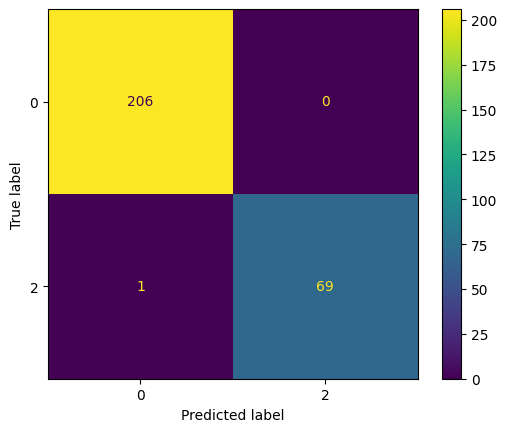

In [64]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=CM_FIFS_shap_cMatrix, display_labels=CM_FIFS_shap_model.classes_)
disp.plot()
plt.show()

In [62]:
#Classifier results with newtry_feature_importance

In [ ]:
#Try####

vals= np.abs(CM_shap_values).mean(0)

newtry_feature_importance = pd.DataFrame(list(zip(CP_MT_X_train.columns, sum(vals))), columns=['col_name','feature_importanCM_vals'])
newtry_feature_importance.sort_values(by=['feature_importanCM_vals'], ascending=False,inplace=True)
newtry_feature_importance

,col_name,feature_importanCM_vals
822,TATCG,324.907479
341,CCCCC,164.339777
96,ACGAA,154.970735
848,TCCAA,124.460883
111,ACGTT,116.747471
...,...,...
53,AATCC,0.000000
480,CTGAA,0.000000
476,CTCTA,0.000000
475,CTCGT,0.000000


In [80]:
newtry_feature_importance.head(100)

,col_name,feature_importanCM_vals
822,TATCG,324.907479
341,CCCCC,164.339777
96,ACGAA,154.970735
848,TCCAA,124.460883
111,ACGTT,116.747471
...,...,...
246,ATTCG,11.585036
269,CAATC,11.518960
28,AACTA,11.382042
354,CCGAG,11.229052


In [81]:
# Show only feature importances above 0.1

CM_newSHAP_thres_chosen = newtry_feature_importance[newtry_feature_importance["feature_importance_vals"] > 0.02]
CM_newshap_num_chosen = len(CM_newSHAP_thres_chosen)

print(CM_newSHAP_thres_chosen)

print("\nAmount of features with importnace above 0.1 (selected features):", CM_newshap_num_chosen)

    col_name  feature_importanCM_vals
822    TATCG               324.907479
341    CCCCC               164.339777
96     ACGAA               154.970735
848    TCCAA               124.460883
111    ACGTT               116.747471
..       ...                      ...
246    ATTCG                11.585036
269    CAATC                11.518960
28     AACTA                11.382042
354    CCGAG                11.229052
536    GACGA                11.221753

[100 rows x 2 columns]

Amount of features with importnace above 0.1 (selected features): 100


In [82]:
print("Sum of total feature importances: ", sum(newtry_feature_importance.feature_importanCM_vals))
print("Sum of feature importances > 0.1: ", sum(CM_newSHAP_thres_chosen.feature_importanCM_vals))

Sum of total feature importances:  5628.551290067104
Sum of feature importances >=0.1:  3907.5025224662436


In [83]:
# Select features with importance values above 0.1

CM_newshap_selected_feat = newtry_feature_importance[:CM_newshap_num_chosen]['col_name'].tolist()

print(CM_newshap_selected_feat)

['TATCG', 'CCCCC', 'ACGAA', 'TCCAA', 'ACGTT', 'TTACG', 'CGGTA', 'ATTGG', 'TCGTT', 'CAGCC', 'CAGCT', 'TTCGT', 'CCCAG', 'CCTCC', 'CGTTA', 'CTCAG', 'TCGAA', 'TCAGC', 'TTCGA', 'CAGCA', 'TATGG', 'TGTAA', 'GCCTG', 'GGCCT', 'TGACG', 'GGTAC', 'CCTGG', 'CTGAG', 'GGTAT', 'CACAG', 'TGGTA', 'GTCGT', 'ACGAT', 'CCCCT', 'CGATT', 'CTATT', 'CAGTC', 'CCAGG', 'CGATA', 'CGTTG', 'GGCAT', 'TCGAT', 'ATTGA', 'CGTAA', 'CGAAA', 'CCCTG', 'CACCC', 'TTGCG', 'TAACG', 'GTGTG', 'ATACG', 'CCGAT', 'AAAAA', 'TTGGT', 'ATTAC', 'TTTCG', 'GACCT', 'GGGGC', 'ATCCG', 'TATTG', 'CTCCC', 'GGGCC', 'GGGAG', 'ACACA', 'ATCGT', 'AGCAG', 'ACCCC', 'CTGGG', 'CGATG', 'TACGA', 'CCCGG', 'CATTG', 'CAGGG', 'GACGT', 'ACGCT', 'TCCTG', 'ATCAA', 'GCGAA', 'ATCGA', 'TACGT', 'CGCGC', 'AGCCC', 'TGTGT', 'ATCGG', 'AGTCC', 'CGTAT', 'CAGGC', 'GCCAG', 'TACGG', 'AGGGG', 'ATCCA', 'CGTCA', 'GGAGC', 'TCAGA', 'GTTAG', 'ATTCG', 'CAATC', 'AACTA', 'CCGAG', 'GACGA']


In [84]:
CP_MT_X_train.shape

(1104, 1024)

In [85]:
# See original training set

CP_MT_X_train.head(826)


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.003643,0.000792,0.001426,0.002218,0.001584,0.000950,0.000792,0.000950,0.001901,0.001742,...,0.000000,0.002693,0.002059,0.001109,0.001109,0.002534,0.001584,0.001901,0.003168,0.003643
1,0.002914,0.000291,0.000583,0.000291,0.000583,0.000000,0.000000,0.000583,0.000874,0.001457,...,0.000583,0.000291,0.000583,0.000291,0.000000,0.001166,0.000291,0.001166,0.000583,0.000291
2,0.002291,0.001375,0.000458,0.001375,0.000000,0.000917,0.000458,0.001375,0.001375,0.000917,...,0.000917,0.001375,0.000917,0.000458,0.000458,0.000917,0.000917,0.002750,0.000458,0.000458
3,0.000000,0.000990,0.000495,0.000000,0.000990,0.000990,0.000000,0.000495,0.001484,0.000000,...,0.000000,0.000495,0.000990,0.000000,0.001484,0.000495,0.000495,0.000000,0.000000,0.000000
4,0.013061,0.002488,0.004043,0.004354,0.001451,0.001348,0.000415,0.002902,0.003110,0.001244,...,0.000311,0.001762,0.001970,0.000933,0.002591,0.001970,0.002695,0.002384,0.002488,0.003732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,0.004328,0.002331,0.002331,0.002664,0.002997,0.000499,0.000000,0.001665,0.002331,0.002664,...,0.000000,0.002664,0.001998,0.001665,0.001332,0.003329,0.002331,0.001998,0.002664,0.003995
822,0.004830,0.001499,0.002498,0.004997,0.002332,0.001332,0.000333,0.000833,0.001832,0.001166,...,0.000000,0.002498,0.002831,0.001332,0.001832,0.003664,0.006329,0.002998,0.003831,0.008494
823,0.002500,0.000167,0.000500,0.000167,0.000500,0.000667,0.000167,0.000667,0.000667,0.000333,...,0.000167,0.000667,0.001167,0.000167,0.000333,0.000333,0.000333,0.000167,0.000167,0.000500
0,0.003945,0.001255,0.002690,0.002152,0.001435,0.000359,0.001076,0.001435,0.001973,0.001435,...,0.001614,0.001255,0.003407,0.001435,0.001435,0.001973,0.001435,0.001435,0.002869,0.001435


In [86]:
#Create training set with selected features 

CM_X_train_newshap_selected = CP_MT_X_train[CM_newshap_selected_feat]
CM_X_train_newshap_selected.head()

,TATCG,CCCCC,ACGAA,TCCAA,ACGTT,TTACG,CGGTA,ATTGG,TCGTT,CAGCC,...,ATCCA,CGTCA,GGAGC,TCAGA,GTTAG,ATTCG,CAATC,AACTA,CCGAG,GACGA
0,0.000000,0.001267,0.000475,0.001584,0.000000,0.000158,0.000158,0.000950,0.000317,0.000792,...,0.001267,0.000158,0.001584,0.001267,0.000475,0.000158,0.000792,0.000950,0.001901,0.000000
1,0.000000,0.003205,0.000000,0.001166,0.000583,0.000000,0.000000,0.000583,0.000291,0.004662,...,0.000291,0.000000,0.003497,0.001748,0.000583,0.000291,0.000000,0.000291,0.001457,0.000000
2,0.000458,0.000458,0.000000,0.002750,0.000000,0.000000,0.000000,0.000458,0.000458,0.001833,...,0.000917,0.000458,0.001833,0.002291,0.000458,0.000458,0.000000,0.000917,0.000917,0.000458
3,0.000000,0.004948,0.000000,0.000990,0.000000,0.000000,0.000000,0.000000,0.000000,0.003464,...,0.000990,0.000000,0.002474,0.001484,0.000000,0.000000,0.000000,0.000000,0.000495,0.000990
4,0.000000,0.000622,0.000415,0.001037,0.000207,0.000207,0.000000,0.001244,0.000104,0.001037,...,0.001037,0.000000,0.001037,0.001140,0.001037,0.000207,0.000415,0.001659,0.000207,0.000415


In [87]:
# Check whether columns in new training set are the same featues are the ones selected
if(list(CM_X_train_newshap_selected.columns) == CM_newshap_selected_feat):
    print("Selected and column features are the same; properly selected");
else:
    print("Features not selected properly")

Selected and column features are the same; properly selected


In [88]:
# Check whether number of variables/sequences of training set is the same as number of labels (no change should have been made to the sequences (rows), only to the features (columns)) 
print("Shape of X_train_selected (number of variables/sequences):", CM_X_train_newshap_selected.shape)
print("Shape of y_train (number of labels):", CP_MT_y_train.shape)

Shape of X_train_selected (number of variables/sequences): (1104, 100)
Shape of y_train (number of labels): (1104,)


In [89]:
# Create pool object for selected feature data
print("Original number of features:", len(CM_feature_names), "\n Number of selected features:", len(CM_newshap_selected_feat))

CM_newshap_selected_train_pool = Pool(CM_X_train_newshap_selected, CP_MT_y_train, feature_names=CM_newshap_selected_feat)

Original number of features: 1024 
 Number of selected features: 100


In [90]:
#Create new model for data with selected features
CM_FIFS_newshap_model = CatBoostClassifier(loss_function="MultiClass")

# Fit new data into same model as before

CM_FIFS_newshap_model.fit(CM_newshap_selected_train_pool)

Learning rate set to 0.079527
0:	learn: 0.6359069	total: 78.9ms	remaining: 1m 18s
1:	learn: 0.5860164	total: 98ms	remaining: 48.9s
2:	learn: 0.5398971	total: 111ms	remaining: 37s
3:	learn: 0.4998063	total: 125ms	remaining: 31.1s
4:	learn: 0.4653281	total: 139ms	remaining: 27.7s
5:	learn: 0.4325161	total: 154ms	remaining: 25.5s
6:	learn: 0.4030002	total: 168ms	remaining: 23.9s
7:	learn: 0.3772330	total: 182ms	remaining: 22.6s
8:	learn: 0.3530650	total: 197ms	remaining: 21.6s
9:	learn: 0.3314076	total: 228ms	remaining: 22.6s
10:	learn: 0.3106960	total: 245ms	remaining: 22.1s
11:	learn: 0.2919670	total: 262ms	remaining: 21.6s
12:	learn: 0.2744920	total: 279ms	remaining: 21.1s
13:	learn: 0.2598854	total: 295ms	remaining: 20.7s
14:	learn: 0.2455660	total: 309ms	remaining: 20.3s
15:	learn: 0.2324850	total: 322ms	remaining: 19.8s
16:	learn: 0.2211207	total: 335ms	remaining: 19.4s
17:	learn: 0.2092669	total: 351ms	remaining: 19.1s
18:	learn: 0.1981200	total: 371ms	remaining: 19.2s
19:	learn: 0

In [91]:
#Check parameters used in this model fit

CM_FIFS_newshap_params = CM_FIFS_newshap_model.get_all_params()
print("Basic model parameters:", CM_FIFS_newshap_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [0, 2], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'MultiClass', 'learning_rate': 0.07952699810266495,

In [92]:
#Prediction using X_test only for selected features data
CM_FIFS_newshap_y_pred = CM_FIFS_newshap_model.predict(CP_MT_X_test)

#Predication probability for selected features data

CM_FIFS_newshap_y_prob = CM_FIFS_newshap_model.predict_proba(CP_MT_X_test)

In [93]:
# Calculate F1 score and get classification report

CM_FIFS_newshap_f1 = f1_score(CP_MT_y_test, CM_FIFS_newshap_y_pred, average='macro')
print(f"F1 Score: {CM_FIFS_newshap_f1}")

CM_FIFS_newshap_cr = classification_report(CP_MT_y_test, CM_FIFS_newshap_y_pred, digits=3)
print(CM_FIFS_newshap_cr)

print('Accuracy score: ', accuracy_score(CP_MT_y_test, CM_FIFS_newshap_y_pred))
# print('Roc auc score : ', roc_auc_score(CP_MT_y_test, CM_FIFS_newshap_y_prob))

F1 Score: 0.9951922239448151
              precision    recall  f1-score   support

           0      0.995     1.000     0.998       206
           2      1.000     0.986     0.993        70

    accuracy                          0.996       276
   macro avg      0.998     0.993     0.995       276
weighted avg      0.996     0.996     0.996       276

Accuracy score:  0.9963768115942029


In [94]:
# Confusion matrix for selected data

print("real values shape:", CP_MT_y_test.shape)
print("prediction shape:", CM_FIFS_newshap_y_pred.shape)

CM_FIFS_newshap_y_pred_fl = CM_FIFS_newshap_y_pred
print("flattened prediction values shape:", CM_FIFS_newshap_y_pred_fl.ravel().shape, "\n")

CM_FIFS_newshap_cMatrix = confusion_matrix(CP_MT_y_test, CM_FIFS_newshap_y_pred_fl)
print(CM_FIFS_newshap_cMatrix)

real values shape: (276,)
prediction shape: (276, 1)
flattened prediction values shape: (276,) 

[[206   0]
 [  1  69]]


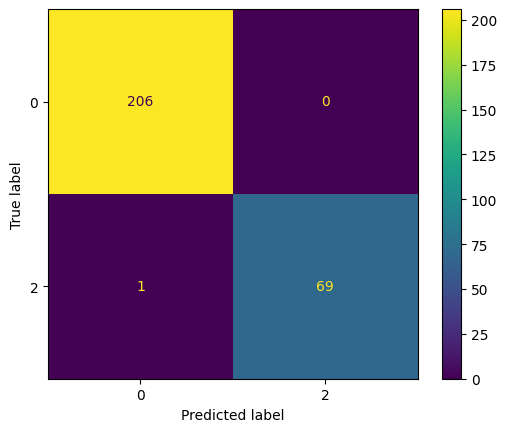

In [95]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=CM_FIFS_newshap_cMatrix, display_labels=CM_FIFS_newshap_model.classes_)
disp.plot()
plt.show()